In [1]:
import pandas as pd
import numpy as np

from dateutil import parser
from datetime import datetime

import matplotlib.pyplot as plt

from statsmodels.tsa.ar_model import AutoReg

import tensorflow as tf

print(tf.__version__)

2.1.0


In [2]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import SimpleRNN

## Predição

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [4]:
#time = np.arange(4 * 365 + 1, dtype="float32")
time = np.arange(4 * 365 , dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

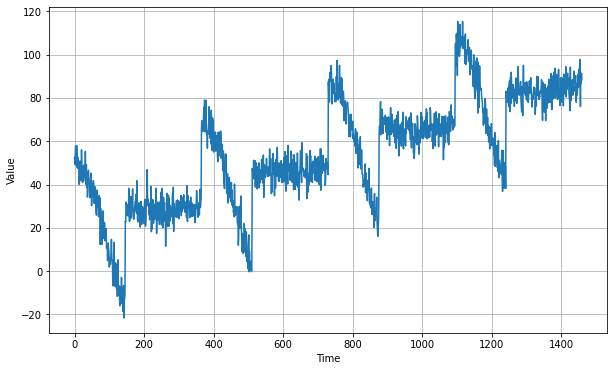

In [5]:
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

## Preparando dataset
* treino recebe o seguinte formato: 
    * itens no dataset
    * número de itens em cada série
    * número de features em cada série (univariada ou multivariada)

In [54]:
print(series.shape)
s2=series.reshape(365,4)

target = s2[:, -1] # última coluna
dataset = s2[:, :-1] # tudo menos última coluna
dataset=dataset.reshape(365,3,1)
print(target.shape)
print(dataset.shape)

(1460,)
(365,)
(365, 3, 1)


In [55]:
model = Sequential()
model.add(SimpleRNN(128, input_shape = (dataset.shape[1], dataset.shape[2]), activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation='linear'))

model.compile(loss = 'mean_squared_error',
              optimizer = 'adam',
              metrics = ['mse'])

history = model.fit(dataset, target, 
    epochs=50, batch_size=4, verbose=2, 
    validation_split = 0.20)

Train on 292 samples, validate on 73 samples
Epoch 1/50
292/292 - 1s - loss: 286.1684 - mse: 286.1684 - val_loss: 37.7740 - val_mse: 37.7740
Epoch 2/50
292/292 - 1s - loss: 47.4030 - mse: 47.4030 - val_loss: 37.8797 - val_mse: 37.8797
Epoch 3/50
292/292 - 1s - loss: 49.5247 - mse: 49.5247 - val_loss: 37.3803 - val_mse: 37.3803
Epoch 4/50
292/292 - 1s - loss: 55.0370 - mse: 55.0370 - val_loss: 51.3814 - val_mse: 51.3814
Epoch 5/50
292/292 - 1s - loss: 48.1928 - mse: 48.1928 - val_loss: 41.0753 - val_mse: 41.0754
Epoch 6/50
292/292 - 1s - loss: 48.2499 - mse: 48.2499 - val_loss: 42.3116 - val_mse: 42.3116
Epoch 7/50
292/292 - 1s - loss: 54.3106 - mse: 54.3106 - val_loss: 92.0537 - val_mse: 92.0537
Epoch 8/50
292/292 - 1s - loss: 48.2824 - mse: 48.2824 - val_loss: 41.8038 - val_mse: 41.8038
Epoch 9/50
292/292 - 1s - loss: 47.1746 - mse: 47.1746 - val_loss: 37.2818 - val_mse: 37.2818
Epoch 10/50
292/292 - 1s - loss: 49.7680 - mse: 49.7680 - val_loss: 57.0048 - val_mse: 57.0048
Epoch 11/50


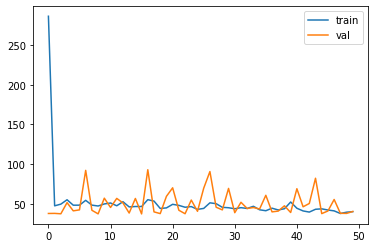

In [56]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

## Return_sequences=True 
* Permite empilhar camadas RNN

In [58]:
model = Sequential()
model.add(SimpleRNN(128, input_shape = (dataset.shape[1], dataset.shape[2]), activation = 'relu', return_sequences=True))
#model.add(SimpleRNN(128, input_shape = (dataset.shape[1], dataset.shape[2]), activation = 'relu'))
model.add(SimpleRNN(128, input_shape = (dataset.shape[1], dataset.shape[2]), activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation='linear'))

model.compile(loss = 'mean_squared_error',
              optimizer = 'adam',
              metrics = ['mse'])

history = model.fit(dataset, target, 
    epochs=50, batch_size=4, verbose=2, 
    validation_split = 0.20)

Train on 292 samples, validate on 73 samples
Epoch 1/50
292/292 - 2s - loss: 145.7426 - mse: 145.7426 - val_loss: 44.4751 - val_mse: 44.4751
Epoch 2/50
292/292 - 1s - loss: 61.5383 - mse: 61.5383 - val_loss: 73.3459 - val_mse: 73.3459
Epoch 3/50
292/292 - 1s - loss: 57.4766 - mse: 57.4767 - val_loss: 135.1487 - val_mse: 135.1487
Epoch 4/50
292/292 - 1s - loss: 53.6595 - mse: 53.6595 - val_loss: 38.2349 - val_mse: 38.2349
Epoch 5/50
292/292 - 1s - loss: 55.0005 - mse: 55.0005 - val_loss: 60.7018 - val_mse: 60.7017
Epoch 6/50
292/292 - 1s - loss: 51.2176 - mse: 51.2175 - val_loss: 83.4156 - val_mse: 83.4156
Epoch 7/50
292/292 - 1s - loss: 47.5983 - mse: 47.5983 - val_loss: 67.3436 - val_mse: 67.3436
Epoch 8/50
292/292 - 1s - loss: 51.3238 - mse: 51.3238 - val_loss: 42.5123 - val_mse: 42.5123
Epoch 9/50
292/292 - 1s - loss: 55.6590 - mse: 55.6590 - val_loss: 44.6531 - val_mse: 44.6531
Epoch 10/50
292/292 - 1s - loss: 58.7970 - mse: 58.7970 - val_loss: 97.5799 - val_mse: 97.5799
Epoch 11/5

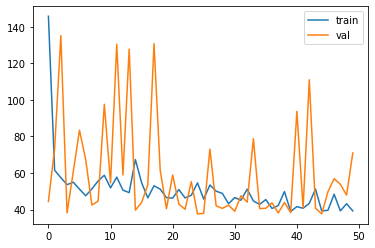

In [59]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

## Exemplo com LSTM

* pool2.csv : Previsão da poluição do ar

* Conjunto de dados que relata o clima e o nível de poluição a cada hora durante cinco anos na embaixada dos EUA em Pequim, China.

* pm2.5: concentração de PM2.5
* DEWP: Ponto de Orvalho
* TEMP: Temperatura
* PRES: Pressão
* cbwd: Direção combinada do vento
* Iws: velocidade acumulada do vento
* Is: horas acumuladas de neve
* Ir: Horas acumuladas de chuva

In [9]:
# load dataset
dataset = pd.read_csv('poll2.csv', header=0, index_col=0)
print(dataset.info())
print(dataset.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 43800 entries, 2010-01-02 00:00:00 to 2014-12-31 23:00:00
Data columns (total 8 columns):
pollution    43800 non-null float64
dew          43800 non-null int64
temp         43800 non-null float64
press        43800 non-null float64
wnd_dir      43800 non-null object
wnd_spd      43800 non-null float64
snow         43800 non-null int64
rain         43800 non-null int64
dtypes: float64(4), int64(3), object(1)
memory usage: 3.0+ MB
None
(43800, 8)


## Dataset com mais de uma informação por step temporal

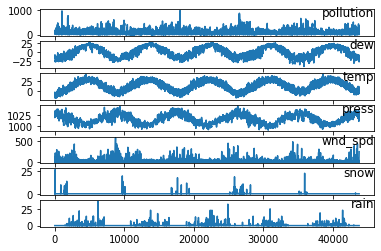

In [108]:
values = dataset.values

# plotando colunas das séries
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

## Prepara dados

In [27]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    print('colunas ' , n_vars)
    
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # para cada coluna cria t+1, ...t+n
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # agrega colunas novas
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop NAN
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg
 


In [31]:
# load dataset
dataset = read_csv('poll2.csv', header=0, index_col=0)
values = dataset.values

# codifica direcao do vento
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

#  converte tudo para float
values = values.astype('float32')

# normalizacao
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


# cria coluna no tempo t+1 para previsao supervisionada
reframed = series_to_supervised(scaled, 1, 1)

# drop columns que nao serão preditas (fica apenas poluicao)
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())
 
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
#train = values[:n_train_hours, :]
#test = values[n_train_hours:, :]
test = values[:n_train_hours, :]
train = values[n_train_hours:, :]

# split X e y
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# reshape para 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

colunas  8
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  
(35039, 8) (35039,) (8760, 8) (8760,)
(35039, 1, 8) (35039,) (8760, 1, 8) (8760,)


## Rede Neural MLP

In [34]:
model = Sequential()
model.add(Dense(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 8760 samples, validate on 35037 samples
Epoch 1/50
8760/8760 - 2s - loss: 0.0539 - val_loss: 0.1041
Epoch 2/50
8760/8760 - 2s - loss: 0.0287 - val_loss: 0.0730
Epoch 3/50
8760/8760 - 2s - loss: 0.0252 - val_loss: 0.0587
Epoch 4/50
8760/8760 - 2s - loss: 0.0244 - val_loss: 0.0468
Epoch 5/50
8760/8760 - 2s - loss: 0.0242 - val_loss: 0.0365
Epoch 6/50
8760/8760 - 2s - loss: 0.0238 - val_loss: 0.0293
Epoch 7/50
8760/8760 - 2s - loss: 0.0238 - val_loss: 0.0254
Epoch 8/50
8760/8760 - 2s - loss: 0.0235 - val_loss: 0.0259
Epoch 9/50
8760/8760 - 2s - loss: 0.0235 - val_loss: 0.0251
Epoch 10/50
8760/8760 - 2s - loss: 0.0235 - val_loss: 0.0227
Epoch 11/50
8760/8760 - 2s - loss: 0.0234 - val_loss: 0.0217
Epoch 12/50
8760/8760 - 2s - loss: 0.0234 - val_loss: 0.0235
Epoch 13/50
8760/8760 - 2s - loss: 0.0232 - val_loss: 0.0235
Epoch 14/50
8760/8760 - 2s - loss: 0.0232 - val_loss: 0.0225
Epoch 15/50
8760/8760 - 2s - loss: 0.0233 - val_loss: 0.0217
Epoch 16/50
8760/8760 - 2s - loss: 0.0236 - v

## Avalia rede neural

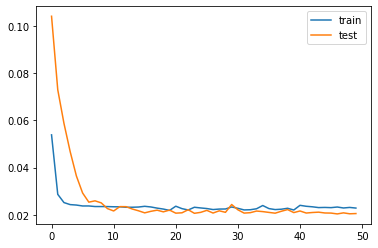

ValueError: Found array with dim 3. Estimator expected <= 2.

In [35]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
yhat = model.predict(test_X)

rmse = sqrt(mean_squared_error(yhat, test_y))
print('RMSE: %.3f' % rmse)

## Rede Neural LSTM

In [37]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 8760 samples, validate on 35037 samples
Epoch 1/50
8760/8760 - 4s - loss: 0.0519 - val_loss: 0.0722
Epoch 2/50
8760/8760 - 3s - loss: 0.0271 - val_loss: 0.0413
Epoch 3/50
8760/8760 - 3s - loss: 0.0215 - val_loss: 0.0238
Epoch 4/50
8760/8760 - 3s - loss: 0.0212 - val_loss: 0.0210
Epoch 5/50
8760/8760 - 3s - loss: 0.0206 - val_loss: 0.0194
Epoch 6/50
8760/8760 - 3s - loss: 0.0201 - val_loss: 0.0190
Epoch 7/50
8760/8760 - 3s - loss: 0.0200 - val_loss: 0.0193
Epoch 8/50
8760/8760 - 3s - loss: 0.0192 - val_loss: 0.0180
Epoch 9/50
8760/8760 - 3s - loss: 0.0189 - val_loss: 0.0178
Epoch 10/50
8760/8760 - 3s - loss: 0.0185 - val_loss: 0.0175
Epoch 11/50
8760/8760 - 3s - loss: 0.0180 - val_loss: 0.0171
Epoch 12/50
8760/8760 - 3s - loss: 0.0176 - val_loss: 0.0168
Epoch 13/50
8760/8760 - 3s - loss: 0.0173 - val_loss: 0.0164
Epoch 14/50
8760/8760 - 3s - loss: 0.0169 - val_loss: 0.0162
Epoch 15/50
8760/8760 - 3s - loss: 0.0165 - val_loss: 0.0160
Epoch 16/50
8760/8760 - 3s - loss: 0.0161 - v

## Avalia rede neural

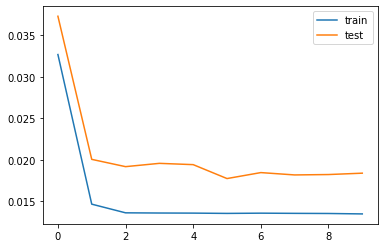

RMSE: 0.033


In [26]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

yhat = model.predict(test_X)

rmse = sqrt(mean_squared_error(yhat, test_y))
print('RMSE: %.3f' % rmse)

## Série temporal com mais de um item por série

In [32]:
# load dataset
dataset = read_csv('poll2.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_hours = 3
n_features = 8
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)
 
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

colunas  8
(43797, 32)
(8760, 24) 8760 (8760,)
(8760, 3, 8) (8760,) (35037, 3, 8) (35037,)


## from_tensor_slices
* Método para ler o dataset obtendo apenas os elementos a serem usados no processamento de cada época apenas
* O dataset completo não preciso ser carregado na memória

In [25]:
series[:20]
type(x_train)

numpy.ndarray

## usando from_tensor_slices
* Separando apenas 20 elementos e criando um objeto para ler a partir de um array numpy

In [26]:
x_train = series[:20]
dataset1 = tf.data.Dataset.from_tensor_slices(x_train)

* Iterador pelos elementos do objeto from_tensor_slices()

In [27]:
for element in dataset1.as_numpy_iterator(): 
   print(element)

52.48357
49.35275
53.314735
57.711823
48.934444
48.931244
57.982895
53.897125
47.67393
52.68371
47.591717
47.506374
50.959415
40.086178
40.919415
46.612473
44.228207
50.720642
44.454983
41.76799


## Explorando diferentes parâmetros do objeto Dataset (from_tensor_slices)
* window: obtem intervalos de dados de tamanho definido do dataset completo
* parâmetro shift indica quantos elementos devem ser avançados a série completa para obter uma nova janela
* parâmetro drop_remainder : indica que quando a quantidade de dados for inferior ao tamanho da janela pré-definido, essa última parte pode ser descartada ou utilizada em tamanho menor
    * Isso influencia na definicao da entrada do algoritmo de predição
    * caso o algoritmo não permita utilizar um temanho variável, será necessário atribuir true a esse parâmetro
    
* Mapeia map_func nesse conjunto de dados e nivela o resultado.

Use flat_map se quiser garantir que a ordem do seu conjunto de dados permaneça a mesma. Por exemplo, para nivelar um conjunto de dados de lotes em um conjunto de dados de seus elementos:


In [28]:
window_size = 2

#cria um dataset maior a partir de um dataset de uma única sequencia
dataset1 = tf.data.Dataset.from_tensor_slices(x_train)
#criar janelas de tamanho fixo na sequência
dataset1 = dataset1.window(window_size + 1, shift=2, drop_remainder=False)
# transforma em estrutura falt
dataset1 = dataset1.flat_map(lambda window: window.batch(window_size + 1))
for element in dataset1.as_numpy_iterator(): 
   print(element)

[52.48357  49.35275  53.314735]
[53.314735 57.711823 48.934444]
[48.934444 48.931244 57.982895]
[57.982895 53.897125 47.67393 ]
[47.67393  52.68371  47.591717]
[47.591717 47.506374 50.959415]
[50.959415 40.086178 40.919415]
[40.919415 46.612473 44.228207]
[44.228207 50.720642 44.454983]
[44.454983 41.76799 ]


## Explorando batches e shuffle
* usando o parâmetro window é possível obter diversas amostras de sub-sequências a partir de uma única sequência
* Opção batch permite obter um conjunto dessas subsequências em cada item do iterador
* A opção shuffle permite que as subsequências obtidas sejam de diferentes partes da sequência completa

In [29]:
shuffle_buffer_size=20
shuffle_buffer=shuffle_buffer_size
window_size = 4
batch_size = 3
#cria um dataset maior a partir de um dataset de uma única sequencia
dataset1 = tf.data.Dataset.from_tensor_slices(x_train)
#criar janelas de tamanho fixo na sequência
dataset1 = dataset1.window(window_size + 1, shift=1, drop_remainder=True)
#
dataset1 = dataset1.flat_map(lambda window: window.batch(window_size + 1))
#
dataset1 = dataset1.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
#cria batches
dataset1 = dataset1.batch(batch_size).prefetch(1)

In [30]:
for element in dataset1.as_numpy_iterator(): 
   print(element)

(array([[50.959415, 40.086178, 40.919415, 46.612473],
       [57.982895, 53.897125, 47.67393 , 52.68371 ],
       [47.591717, 47.506374, 50.959415, 40.086178]], dtype=float32), array([44.228207, 47.591717, 40.919415], dtype=float32))
(array([[52.48357 , 49.35275 , 53.314735, 57.711823],
       [40.086178, 40.919415, 46.612473, 44.228207],
       [53.897125, 47.67393 , 52.68371 , 47.591717]], dtype=float32), array([48.934444, 50.720642, 47.506374], dtype=float32))
(array([[40.919415, 46.612473, 44.228207, 50.720642],
       [52.68371 , 47.591717, 47.506374, 50.959415],
       [57.711823, 48.934444, 48.931244, 57.982895]], dtype=float32), array([44.454983, 40.086178, 53.897125], dtype=float32))
(array([[49.35275 , 53.314735, 57.711823, 48.934444],
       [48.934444, 48.931244, 57.982895, 53.897125],
       [47.67393 , 52.68371 , 47.591717, 47.506374]], dtype=float32), array([48.931244, 47.67393 , 50.959415], dtype=float32))
(array([[53.314735, 57.711823, 48.934444, 48.931244],
       [46

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

## Lambda Layer
* camada de processamento adicional (não é treinada)
* expand_dims reshape da matriz
* x: x * 100 multiplica valores obtidos por 100
* Modelo com callback para alterar dinamicamente laerning rate

## Montando Rede Neural para predição

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

#window_size=10

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=10, callbacks=[lr_schedule])

Epoch 1/10
8/8 [==============================] - 1s 163ms/step - loss: 196.6258 - mae: 197.0189
Epoch 2/10
8/8 [==============================] - 0s 35ms/step - loss: 195.7528 - mae: 196.2360
Epoch 3/10
8/8 [==============================] - 0s 33ms/step - loss: 194.4658 - mae: 194.9796
Epoch 4/10
8/8 [==============================] - 0s 37ms/step - loss: 192.8613 - mae: 193.3948
Epoch 5/10
8/8 [==============================] - 0s 33ms/step - loss: 191.1328 - mae: 191.5367
Epoch 6/10
8/8 [==============================] - 0s 35ms/step - loss: 188.8058 - mae: 189.4040
Epoch 7/10
8/8 [==============================] - 0s 37ms/step - loss: 186.3877 - mae: 186.9576
Epoch 8/10
8/8 [==============================] - 0s 32ms/step - loss: 183.6929 - mae: 184.1687
Epoch 9/10
8/8 [==============================] - 0s 38ms/step - loss: 180.4382 - mae: 180.9923
Epoch 10/10
8/8 [==============================] - 0s 35ms/step - loss: 176.7068 - mae: 177.3471


In [10]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

KeyboardInterrupt: 